In [130]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [131]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('images') if isfile(join('images', f))])

In [132]:
image_path_example = f'images/{images_paths[0]}'

(1200, 1600, 3)


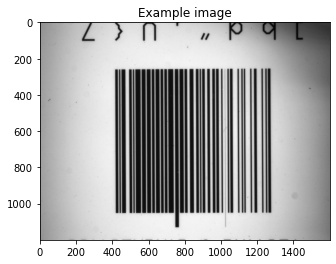

In [133]:
image = cv2.imread(image_path_example)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Example image');

## 1) COMPUTING REGIONS WITH HIGH HORIZONTAL DERIVATIVE AND LOW VERTICAL DERIVATIVE 

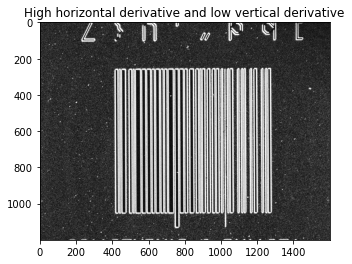

In [135]:
# Compute the Scharr gradient magnitude representation of the images in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)

# Subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(gradient, 'gray')
plt.title('High horizontal derivative and low vertical derivative');

## 2) BINARY THRESHOLDING (OTSU'S ALGORITHM)

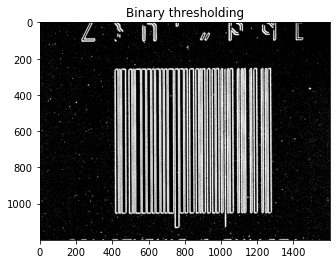

In [136]:
# Threshold, Otsu's algorithm
ret2,thresh = cv2.threshold(gradient,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure()
plt.imshow(thresh, 'gray')
plt.title('Binary thresholding');

### Remark: why don't we directly apply thresholding on the input image?
Because, using the derivative, we filter the image, keeping only the vertical edges: we filter the image, removing not interesting stuff.

Let's see an example.

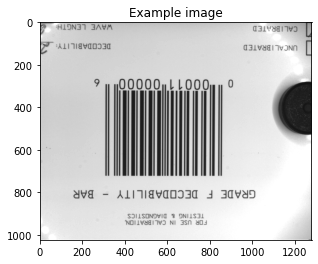

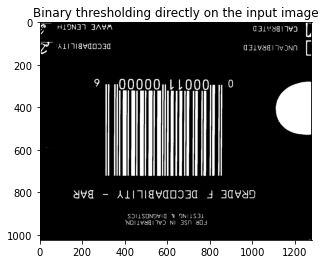

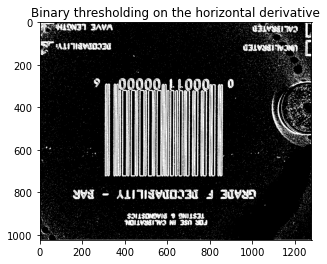

In [139]:
image_path_example_tmp = f'images/{images_paths[-1]}'

image_tmp = cv2.imread(image_path_example_tmp)
gray_tmp = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray_tmp, 'gray')
plt.title('Example image');

ret2,thresh_tmp = cv2.threshold(gray_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure()
plt.imshow(255-thresh_tmp, 'gray')
plt.title('Binary thresholding directly on the input image');

ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray_tmp, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray_tmp, ddepth=ddepth, dx=0, dy=1, ksize=-1)
gradient_tmp = cv2.subtract(gradX, gradY)
gradient_tmp = cv2.convertScaleAbs(gradient_tmp)
ret2,thresh_tmp = cv2.threshold(gradient_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure()
plt.imshow(thresh_tmp, 'gray')
plt.title('Binary thresholding on the horizontal derivative');

## 3) MAKING THE BARS MORE VERTICAL (CLOSING MORPHOLOGICAL OPERATOR)

CLosing with a $5 \times 5$ cross-shaped structuring elements. Aim: making the vertical bars more vertical.

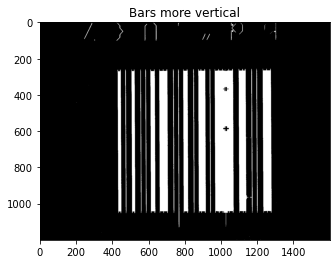

In [117]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')
plt.title('Bars more vertical');

The impact of this step is not clear on this particular case.

This operation is useful with barcodes which are more rotated. In such cases, the derivative (and, therefore,the binary image) contains vertical bars which are shredded and not perfectly straight. The importance of this operation will be better explained in the next section.

## 4) KEEPING ONLY LONG VERTICAL BARS (OPENING OPERATION)

**Problem: how to decide the length? Not scale inavriance!**

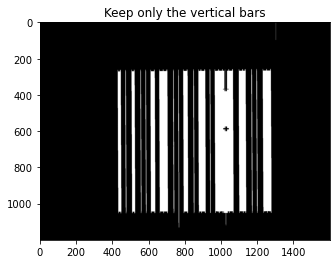

In [118]:
# Keep only vertical bars
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened, 'gray')
plt.title('Keep only the vertical bars');

### Why do we need to make the vertical bars more straight?

Now, an example showing the importance of the step 3) is shown. As said before, this step is important when the barcode is more rotated: in such case, the vertical bars in the derivative image are more "oblique" and shuddered. In such case, detecting the long vertical bars only is not effective.

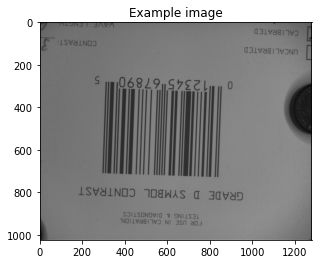

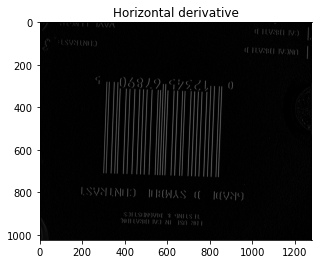

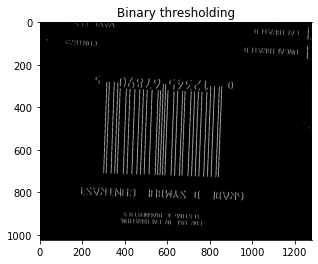

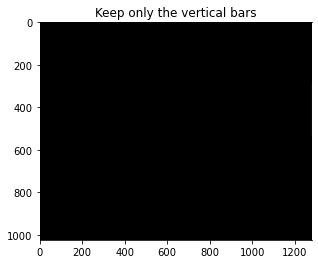

In [119]:
image_path_example_tmp = f'images/{images_paths[26]}'

image_tmp = cv2.imread(image_path_example_tmp)
gray_tmp = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray_tmp, 'gray')
plt.title('Example image');

kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative_tmp = cv2.filter2D(gray_tmp, -1, kernel_horizontal_derivative)
image_horizontal_derivative_tmp = np.abs(image_horizontal_derivative_tmp)
plt.figure()
plt.imshow(image_horizontal_derivative_tmp, 'gray')
plt.title('Horizontal derivative');

ret2,thresh_tmp = cv2.threshold(image_horizontal_derivative_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure()
plt.imshow(thresh_tmp, 'gray')
plt.title('Binary thresholding');

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened_tmp = cv2.morphologyEx(thresh_tmp, cv2.MORPH_OPEN, kernel)
plt.figure()
plt.imshow(opened_tmp, 'gray')
plt.title('Keep only the vertical bars');

The vertical bars have not been detected! Because they are not perfectly straight.

The aim of step 3) is to make the vertical bars more straight, before their detection.

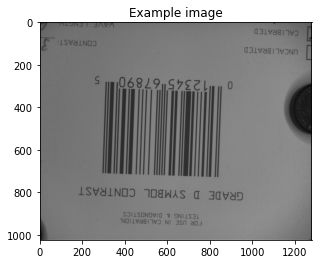

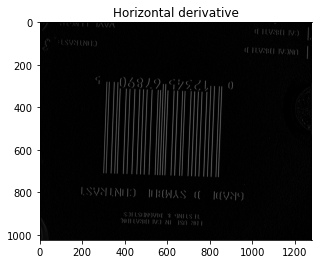

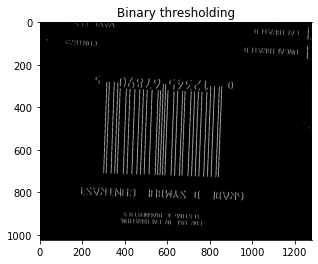

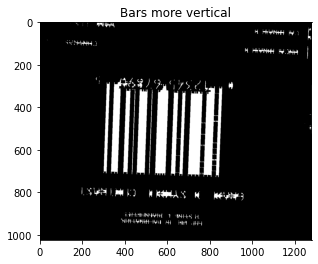

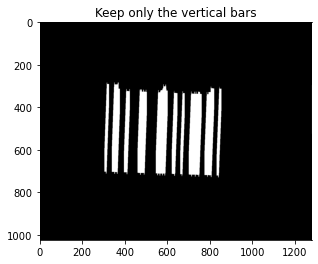

In [120]:
image_path_example_tmp = f'images/{images_paths[26]}'

image_tmp = cv2.imread(image_path_example_tmp)
gray_tmp = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray_tmp, 'gray')
plt.title('Example image');

kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative_tmp = cv2.filter2D(gray_tmp, -1, kernel_horizontal_derivative)
image_horizontal_derivative_tmp = np.abs(image_horizontal_derivative_tmp)
plt.figure()
plt.imshow(image_horizontal_derivative_tmp, 'gray')
plt.title('Horizontal derivative');

ret2,thresh_tmp = cv2.threshold(image_horizontal_derivative_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure()
plt.imshow(thresh_tmp, 'gray')
plt.title('Binary thresholding');

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
closed_tmp = cv2.morphologyEx(thresh_tmp, cv2.MORPH_CLOSE, kernel)
plt.figure()
plt.imshow(closed_tmp, 'gray')
plt.title('Bars more vertical');

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened_tmp = cv2.morphologyEx(closed_tmp, cv2.MORPH_OPEN, kernel)
plt.figure()
plt.imshow(opened_tmp, 'gray')
plt.title('Keep only the vertical bars');

## 5) FILLING THE BOUNDINX BOX (CLOSING OPERATOR)

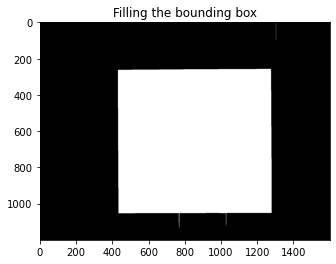

In [122]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
closed1 = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed1, 'gray')
plt.title('Filling the bounding box');

## 6) REMOVING THINGS OUTSIDE THE BOX (OPENING OPERATOR)

Text(0.5, 1.0, 'Removing things outside the box')

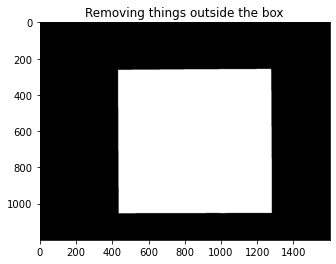

In [58]:
# Remove things outside
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
opened1 = cv2.morphologyEx(closed1, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened1, 'gray')
plt.title('Removing things outside the box')

### Why do we remove things outside the box?
Because small things outside the actual box can negatively affect the orientation of the box. Like in the following example.

In [123]:
# TODO : DELETE
def plot_bounding_box(dilated, gray_image, title=''):
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    gray_tmp = cv2.warpPerspective(gray_image, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray_tmp, 'gray')
    plt.title(title);

In [127]:
def plot_bounding_box(binary_image, gray_image, original_image, title=''):
    cnts = cv2.findContours(binary_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    
    image_bb = original_image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    plt.title(title)

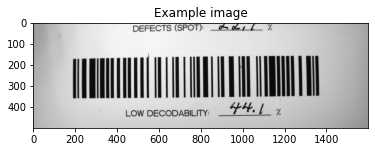

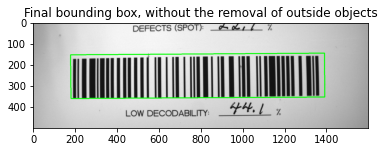

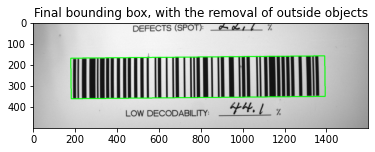

In [129]:
image_path_example_tmp = f'images/{images_paths[15]}'

image_tmp = cv2.imread(image_path_example_tmp)
gray_tmp = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray_tmp, 'gray')
plt.title('Example image');

kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative_tmp = cv2.filter2D(gray_tmp, -1, kernel_horizontal_derivative)
image_horizontal_derivative_tmp = np.abs(image_horizontal_derivative_tmp)

ret2,thresh_tmp = cv2.threshold(image_horizontal_derivative_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
closed_tmp = cv2.morphologyEx(thresh_tmp, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened_tmp = cv2.morphologyEx(closed_tmp, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
closed_tmp1 = cv2.morphologyEx(opened_tmp, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))
dilated_tmp1 = cv2.dilate(closed_tmp1, kernel, iterations=5)

plot_bounding_box(dilated_tmp1, gray_tmp, image_tmp, title='Final bounding box, without the removal of outside objects')

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
opened_tmp1 = cv2.morphologyEx(closed_tmp1, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))
dilated_tmp2 = cv2.dilate(opened_tmp1, kernel, iterations=5)

plot_bounding_box(dilated_tmp2, gray_tmp,  image_tmp, title='Final bounding box, with the removal of outside objects')

### Degree of the opening operation (i.e. size of the structuring element)
It is important that degree of this opening operator (i.e. the size of the structuring elements) is not too high. If it is too high, the bounding box can become too aligned with the image axes, and, therefore, we loose the actual orientation of the barcode. This reflects in the final image, in which the barcode clearly appears as non-perfectly rotated. A short example is now provided.

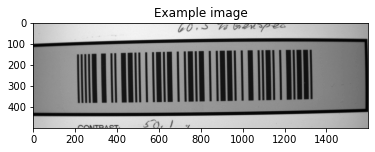

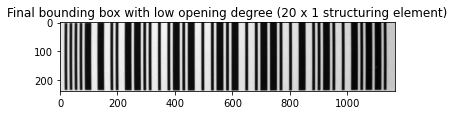

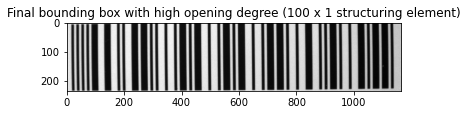

In [67]:
image_path_example_tmp = f'images/{images_paths[17]}'

image_tmp = cv2.imread(image_path_example_tmp)
gray_tmp = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray_tmp, 'gray')
plt.title('Example image');

kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative_tmp = cv2.filter2D(gray_tmp, -1, kernel_horizontal_derivative)
image_horizontal_derivative_tmp = np.abs(image_horizontal_derivative_tmp)

ret2,thresh_tmp = cv2.threshold(image_horizontal_derivative_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
closed_tmp = cv2.morphologyEx(thresh_tmp, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened_tmp = cv2.morphologyEx(closed_tmp, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
closed_tmp1 = cv2.morphologyEx(opened_tmp, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
opened_tmp1 = cv2.morphologyEx(closed_tmp1, cv2.MORPH_OPEN, kernel)
kernel = np.zeros((11,11),np.uint8)
kernel[5,:] = 1
dilated_tmp1 = cv2.dilate(opened_tmp1, kernel, iterations = 5)

plot_bounding_box(dilated_tmp1, gray_tmp, title='Final bounding box with low opening degree (20 x 1 structuring element)')

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
opened_tmp2 = cv2.morphologyEx(closed_tmp1, cv2.MORPH_OPEN, kernel)
kernel = np.zeros((11,11),np.uint8)
kernel[5,:] = 1
dilated_tmp2 = cv2.dilate(opened_tmp2, kernel, iterations = 5)

plot_bounding_box(dilated_tmp2, gray_tmp, title='Final bounding box with high opening degree (100 x 1 structuring element)')

## 7) ENLARGING THE WIDTH OF THE BOX (DILATION OPERATOR)

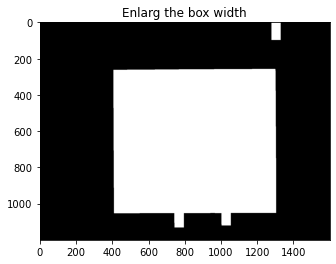

In [93]:
"""kernel = np.zeros((11,11),np.uint8)
kernel[5,:] = 1"""
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))
dilated = cv2.dilate(closed1, kernel, iterations=5)

plt.figure()
plt.imshow(dilated, 'gray')
plt.title('Enlarg the box width');

### Why do we apply this operation?
Because this binary image has been obtained from the gradient image. The computation of the gradient has englighted the bars positions, but it may have made them thinner. This is shown in the following example.

In [105]:
def plot_bounding_box(binary_image, gray_image, original_image, title=''):
    cnts = cv2.findContours(binary_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    
    image_bb = original_image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    plt.title(title)
    
    """coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    gray_tmp = cv2.warpPerspective(gray_image, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray_tmp, 'gray')
    plt.title(title);"""

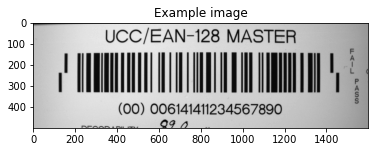

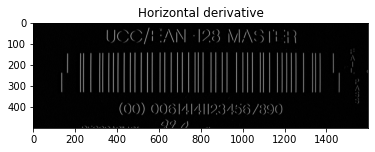

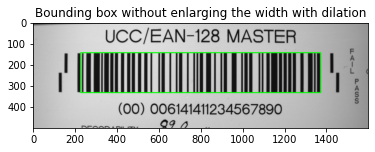

In [106]:
image_path_example_tmp = f'images/{images_paths[16]}'

image_tmp = cv2.imread(image_path_example_tmp)
gray_tmp = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray_tmp, 'gray')
plt.title('Example image');

kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative_tmp = cv2.filter2D(gray_tmp, -1, kernel_horizontal_derivative)
image_horizontal_derivative_tmp = np.abs(image_horizontal_derivative_tmp)
plt.figure()
plt.imshow(image_horizontal_derivative_tmp, 'gray')
plt.title('Horizontal derivative');

ret2,thresh_tmp = cv2.threshold(image_horizontal_derivative_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#plt.figure()
#plt.imshow(thresh_tmp, 'gray')
#plt.title('Binary thresholding');

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
closed_tmp = cv2.morphologyEx(thresh_tmp, cv2.MORPH_CLOSE, kernel)
#plt.figure()
#plt.imshow(closed_tmp, 'gray')
#plt.title('Bars more vertical');

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened_tmp = cv2.morphologyEx(closed_tmp, cv2.MORPH_OPEN, kernel)
#plt.figure()
#plt.imshow(opened_tmp, 'gray')
#plt.title('Keep only the vertical bars');

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
closed_tmp1 = cv2.morphologyEx(opened_tmp, cv2.MORPH_CLOSE, kernel)

plot_bounding_box(closed_tmp1, gray_tmp, image_tmp, title='Bounding box without enlarging the width with dilation')

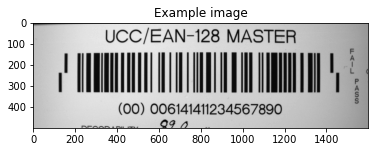

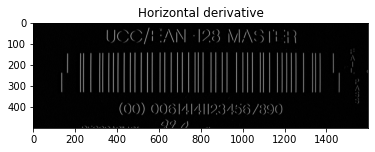

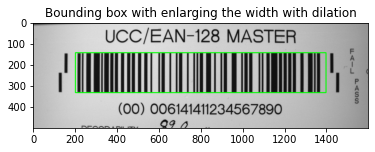

In [107]:
image_path_example_tmp = f'images/{images_paths[16]}'

image_tmp = cv2.imread(image_path_example_tmp)
gray_tmp = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray_tmp, 'gray')
plt.title('Example image');

kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative_tmp = cv2.filter2D(gray_tmp, -1, kernel_horizontal_derivative)
image_horizontal_derivative_tmp = np.abs(image_horizontal_derivative_tmp)
plt.figure()
plt.imshow(image_horizontal_derivative_tmp, 'gray')
plt.title('Horizontal derivative');

ret2,thresh_tmp = cv2.threshold(image_horizontal_derivative_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#plt.figure()
#plt.imshow(thresh_tmp, 'gray')
#plt.title('Binary thresholding');

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
closed_tmp = cv2.morphologyEx(thresh_tmp, cv2.MORPH_CLOSE, kernel)
#plt.figure()
#plt.imshow(closed_tmp, 'gray')
#plt.title('Bars more vertical');

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened_tmp = cv2.morphologyEx(closed_tmp, cv2.MORPH_OPEN, kernel)
#plt.figure()
#plt.imshow(opened_tmp, 'gray')
#plt.title('Keep only the vertical bars');

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
closed_tmp1 = cv2.morphologyEx(opened_tmp, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))
dilated_tmp = cv2.dilate(closed_tmp1, kernel, iterations=5)

plot_bounding_box(dilated_tmp, gray_tmp, image_tmp, title='Bounding box with enlarging the width with dilation')

### End of the preprocessing
After this step, we have finished the pre-processing operations. We are now sure to have a box (i.e. foreground object) containing the whole barcode. In particular:
- along the heigth, we are not interested to contain all the whole bars, since we will shoten each bar to the smallest bars height;
- along the width, the box is slightly bigger than the barcode, because we want to be sure to contain all the bars (since we have to compute the X dimension)

## 8) BOUNDING BOX DETECTION (OpenCV API)

Simple detection of the foreground object with a rectangle bounding box, according to its orientation. OpenCV API.

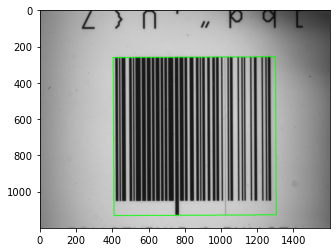

In [108]:
# Bounding box

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
#print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
#print(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

## 9) WARPING: REMOVAL OF PERSPECTIVE DISTORTION AND ROTATION (HOMOGRAPHY)

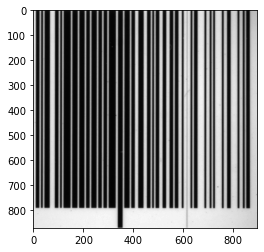

In [109]:
coordinates_source = box.astype('float32')
#print(sorted([tuple(v) for v in coordinates_source], key=lambda t: (t[1],t[0])))
#print(np.sort(coordinates_source))

min_width = coordinates_source[:,0].min()
min_height = coordinates_source[:,1].min()
max_width = coordinates_source[:,0].max()
max_height = coordinates_source[:,1].max()
def normalize(value, axis=0):
    if axis==0:  # Horizontal dimension
        return min_width if (value-min_width<max_width-value) \
                         else max_width
    elif axis==1:  # Vertical dimension
        return min_height if (value-min_height<max_height-value) \
                          else max_height
coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                            normalize(t[0], axis=0))))

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                         dist(coordinates_source[1],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
coordinates_destination = np.array([[0, 0],
                                    [destination_width-1, 0],
                                    [0, destination_height-1],
                                    [destination_width-1, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')